In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_parallel
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor

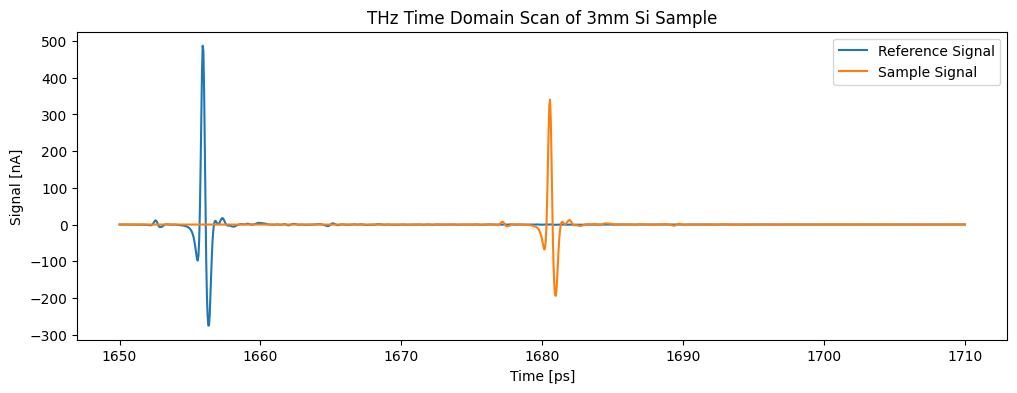

In [2]:
# Load the data
ref_tab = pd.read_csv("Si_data/example_ref_pulse.csv").to_numpy()
sample_tab = pd.read_csv("Si_data/Si.pulse.csv").to_numpy()

# Extract the signals and time data
signal_ref = ref_tab[:, 1]
signal_sample = sample_tab[:, 1]

time_ref = ref_tab[:, 0]
time_sample = sample_tab[:, 0]

# Calculate offset and padding
offset = time_sample[0] - time_ref[0]
time_step = time_ref[1] - time_ref[0]
n_padding = int(offset / time_step)

# Adjust time and signal arrays by padding
time_ref = np.concatenate([time_ref, np.linspace(time_ref[-1], time_sample[-1], n_padding)])
time_sample = np.concatenate([np.linspace(time_ref[0], time_sample[0], n_padding), time_sample])
signal_ref = np.concatenate([signal_ref, np.zeros(n_padding)])
signal_sample = np.concatenate([np.zeros(n_padding), signal_sample])

# Create singular time axis
time_axis = time_ref

# Time and frequency domain parameters
L = len(signal_ref)


# Plot the signals
plt.figure(figsize=(12,4))
plt.plot(time_axis, signal_ref, label="Reference Signal")
plt.plot(time_axis, signal_sample, label="Sample Signal")
plt.title('THz Time Domain Scan of 3mm Si Sample')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

In [3]:
deltat = np.diff(time_axis)[0] # Assume uniformity in time axis (have checked this)

deltat *= 1e-12 # Convert from ps to s

deltat

4.9999999999954525e-14

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.33, 3.5300000000000002)
Layer 1 - k ∈ (-0.01, 0.01)
Bayes params: [((3.4600284103302323+0.00012662158663191356j), 0.003)]


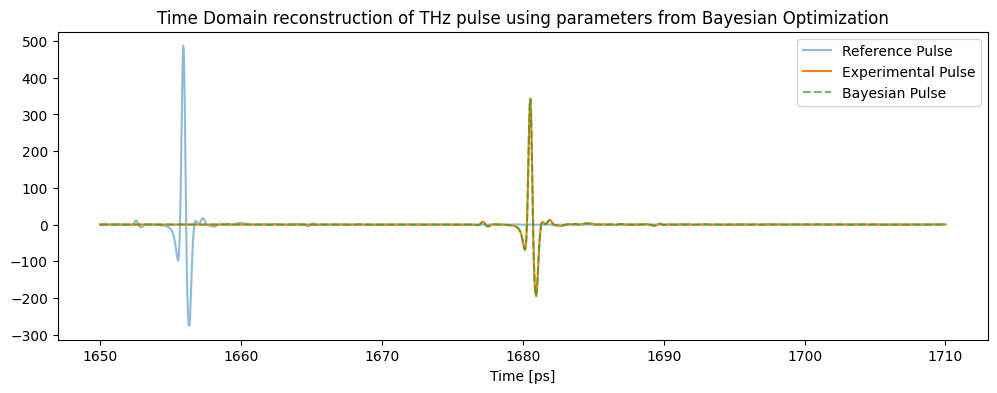

In [4]:
# Convert pulses to tensors
signal_ref_t = torch.tensor(signal_ref, dtype=torch.float32)
signal_sample_t = torch.tensor(signal_sample, dtype=torch.float32)
optimize_mask = [(True, True, False)]

# Initial params: 3.4 & 3mm
init_guess = [((3.43-0j), 3*1e-3)]

bayes_optimizer1 = BayesianLayeredExtractor(signal_ref_t, signal_sample_t, deltat, init_guess, optimize_mask)
bayes_params1 = bayes_optimizer1.bayesian_optimization(50, thickness_delta=10e-6) # Fix thickness uncertainty to +/- 10um

bayes_pulse1 = simulate_parallel(signal_ref_t, bayes_params1, deltat, 0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params1}')
plt.figure(figsize=(12,4))
plt.title('Time Domain reconstruction of THz pulse using parameters from Bayesian Optimization')
plt.plot(time_axis, signal_ref_t, label='Reference Pulse', alpha=0.5)
plt.plot(time_axis, signal_sample_t, label='Experimental Pulse')
plt.plot(time_axis, bayes_pulse1, label='Bayesian Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

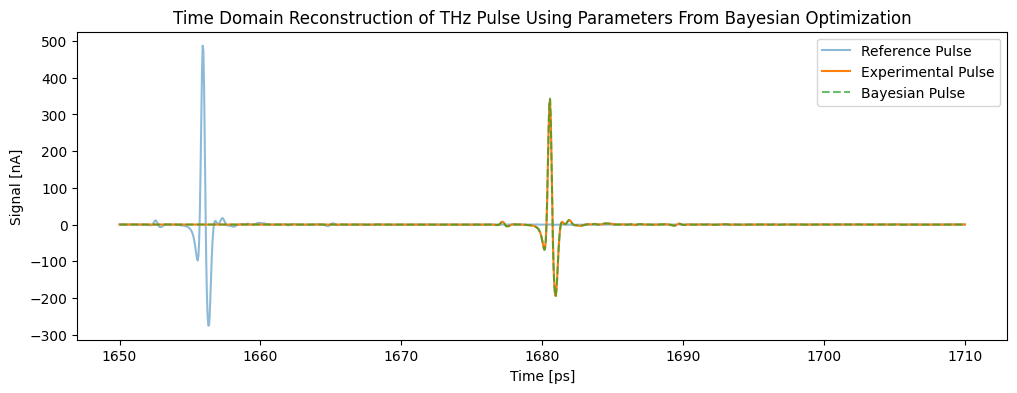

In [12]:
plt.figure(figsize=(12,4))
plt.title('Time Domain Reconstruction of THz Pulse Using Parameters From Bayesian Optimization')
plt.plot(time_axis, signal_ref_t, label='Reference Pulse', alpha=0.5)
plt.plot(time_axis, signal_sample_t, label='Experimental Pulse')
plt.plot(time_axis, bayes_pulse1, label='Bayesian Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

## Optimize with thickness set

Fine-tuning 2 parameters for 100 iterations.
Iteration 9, Loss: 2.438565e+01, Layer 0: n=3.4401, k=-0.00939, D=3000.00 µm
Iteration 19, Loss: 1.766528e+01, Layer 0: n=3.4500, k=-0.01479, D=3000.00 µm
Iteration 29, Loss: 1.436174e+01, Layer 0: n=3.4583, k=-0.01359, D=3000.00 µm
Iteration 39, Loss: 9.823706e+00, Layer 0: n=3.4625, k=-0.00665, D=3000.00 µm
Iteration 49, Loss: 3.893149e+00, Layer 0: n=3.4589, k=0.00193, D=3000.00 µm
Iteration 59, Loss: 1.858719e+00, Layer 0: n=3.4604, k=-0.00092, D=3000.00 µm
Iteration 69, Loss: 6.625770e-01, Layer 0: n=3.4599, k=-0.00043, D=3000.00 µm
Iteration 79, Loss: 4.628083e-01, Layer 0: n=3.4604, k=-0.00027, D=3000.00 µm
Iteration 89, Loss: 2.311569e-01, Layer 0: n=3.4603, k=0.00002, D=3000.00 µm
Iteration 99, Loss: 1.604020e-01, Layer 0: n=3.4603, k=-0.00002, D=3000.00 µm
Optim params: [((3.4601879119873047+4.467814142117277e-05j), 0.0029999997932463884)]


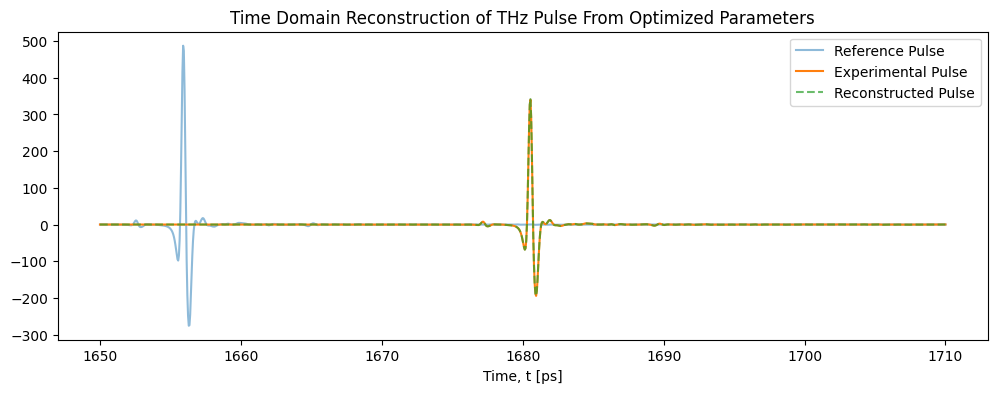

In [5]:

# Initialize gradient optimizer for sample 1
grad_optimizer1 = LayeredExtractor(signal_ref_t, signal_sample_t, deltat, init_guess, optimize_mask, lr=0.001)

# Execute optimization
optim_layers1 = grad_optimizer1.optimize(num_iterations=100, updates=10)
# Save loss history
loss_with_d_set = grad_optimizer1.loss_history

optimized_pulse1 = simulate_parallel(signal_ref_t, optim_layers1, deltat, 0)[1].detach().cpu().numpy()[:L]

print(f'Optim params: {optim_layers1}')
plt.figure(figsize=(12,4))
plt.title('Time Domain Reconstruction of THz Pulse From Optimized Parameters')
plt.plot(time_axis, signal_ref_t, label='Reference Pulse', alpha=0.5)
plt.plot(time_axis, signal_sample_t, label='Experimental Pulse')
plt.plot(time_axis, optimized_pulse1, label='Reconstructed Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

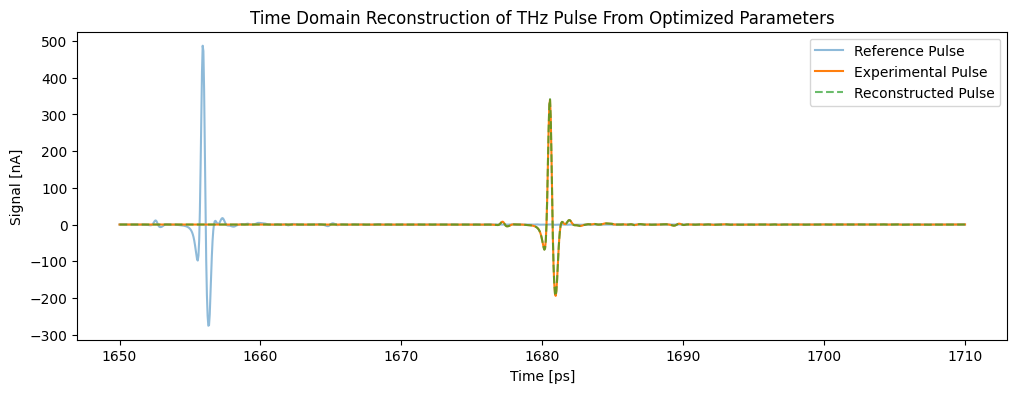

In [11]:
plt.figure(figsize=(12,4))
plt.title('Time Domain Reconstruction of THz Pulse From Optimized Parameters')
plt.plot(time_axis, signal_ref_t, label='Reference Pulse', alpha=0.5)
plt.plot(time_axis, signal_sample_t, label='Experimental Pulse')
plt.plot(time_axis, optimized_pulse1, label='Reconstructed Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

## Optimize with thickness free

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.3, 3.5)
Layer 1 - k ∈ (-0.01, 0.01)
Layer 1 - D ∈ (0.0030399999999999997, 0.00306)
Bayes params: [((3.4265423447795564-0.00027367659699951627j), 0.0030416653796741444)]


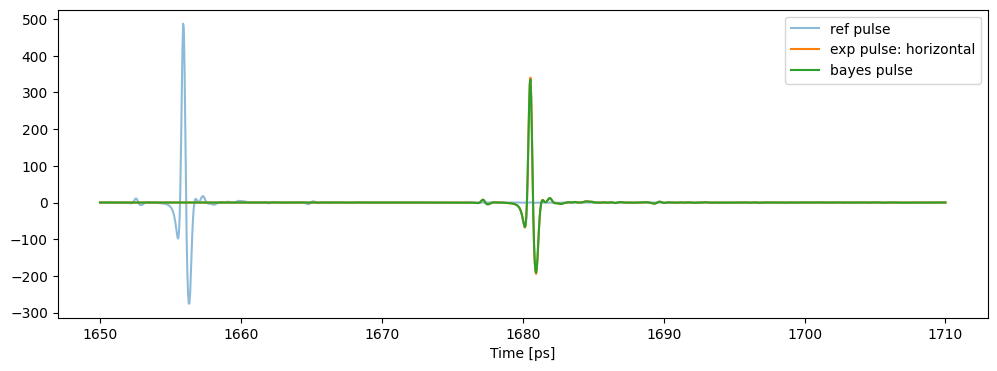

In [6]:
# Convert pulses to tensors
signal_ref_t = torch.tensor(signal_ref, dtype=torch.float32)
signal_sample_t = torch.tensor(signal_sample, dtype=torch.float32)
optimize_mask = [(True, True, True)]

# Initial params: 3.4 & 3mm
init_guess = [((3.4-0j), 3.05*1e-3)]
bayes_optimizer2 = BayesianLayeredExtractor(signal_ref_t, signal_sample_t, deltat, init_guess, optimize_mask)
bayes_params2 = bayes_optimizer2.bayesian_optimization(50, thickness_delta=10e-6) # Fix thickness uncertainty to +/- 10um

bayes_pulse2 = simulate_parallel(signal_ref_t, bayes_params2, deltat, 0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params2}')
plt.figure(figsize=(12,4))
plt.plot(time_axis, signal_ref_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis, signal_sample_t, label='exp pulse: horizontal')
plt.plot(time_axis, bayes_pulse2, label='bayes pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

Fine-tuning 3 parameters for 100 iterations.
Iteration 9, Loss: 3.443775e+00, Layer 0: n=3.4270, k=-0.00060, D=3042.98 µm
Iteration 19, Loss: 1.310582e+00, Layer 0: n=3.4266, k=-0.00058, D=3041.70 µm
Iteration 29, Loss: 2.192728e-01, Layer 0: n=3.4266, k=0.00000, D=3041.82 µm
Iteration 39, Loss: 1.587942e-01, Layer 0: n=3.4266, k=-0.00004, D=3041.86 µm
Iteration 49, Loss: 3.854242e-01, Layer 0: n=3.4265, k=-0.00015, D=3041.47 µm
Iteration 59, Loss: 5.877495e-01, Layer 0: n=3.4266, k=-0.00007, D=3041.71 µm
Iteration 69, Loss: 1.113542e-01, Layer 0: n=3.4265, k=-0.00009, D=3041.42 µm
Iteration 79, Loss: 2.416929e-01, Layer 0: n=3.4265, k=-0.00010, D=3041.52 µm
Iteration 89, Loss: 4.905749e-01, Layer 0: n=3.4266, k=0.00003, D=3041.91 µm
Iteration 99, Loss: 3.153501e-01, Layer 0: n=3.4265, k=-0.00004, D=3041.56 µm
Optim params: [((3.4264559745788574-0.0001316288544330746j), 0.0030413984786719084)]


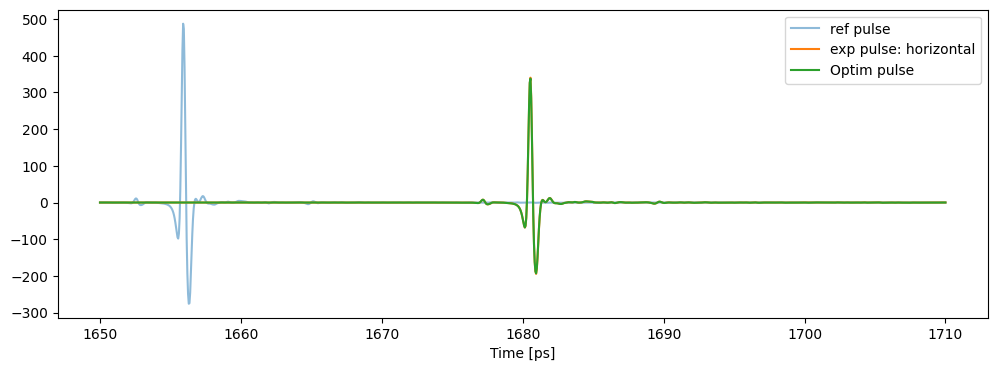

In [7]:
# Initialize gradient optimizer for sample 1
grad_optimizer2 = LayeredExtractor(signal_ref_t, signal_sample_t, deltat, bayes_params2, optimize_mask, lr=0.001)

# Execute optimization
optim_layers2 = grad_optimizer2.optimize(num_iterations=100, updates=10)

# Save loss history
loss_with_d_free = grad_optimizer2.loss_history

optimized_pulse2 = simulate_parallel(signal_ref_t, optim_layers2, deltat, 0)[1].detach().cpu().numpy()[:L]

print(f'Optim params: {optim_layers2}')
plt.figure(figsize=(12,4))
plt.plot(time_axis, signal_ref_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis, signal_sample_t, label='exp pulse: horizontal')
plt.plot(time_axis, optimized_pulse2, label='Optim pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

## Compare loss profiles from gradient model

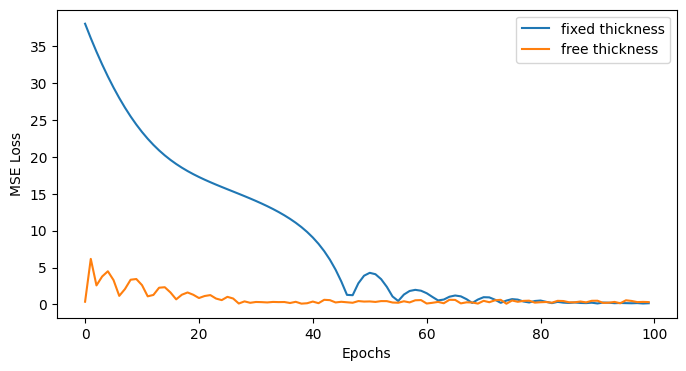

In [8]:

plt.figure(figsize=(8,4))
plt.plot(loss_with_d_set, label='fixed thickness')
plt.plot(loss_with_d_free, label='free thickness')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()